# Network Embeddig Test

## 1. Introduction

The Network Embedding is a collective term for techniques for mapping graph modes to vectors of a renumbers in a multi-dimensional space(Shmueli, 2019). This often refers to mathematical representation. To be useful, a good embedding should preserve the structure of the graphs. The vectors can be then used as input to various network and graph analysis tasks, such as link prediction. The main Machine Learning tasks with network are node classification, link prediction, community detection, and network similarity. 

This report’s main task is to do node classification task. The node classification task is one where the algorithm has to determine the labelling of samples (represented as nodes) by looking at the labels of their neighbours. These models aim to predict non-existing node properties (known as the target report) based on other node properties. Typical models used for node classification consists of large family of graph neural networks(Fey and Lenssen, 2019). This report will reproduce three models: The AROPE, GCN and DeepWalk model by a same dataset. Then compare their model performance by Accuracy

This report includes four 

## 2. Methodology

### 2.1 Graph’s representation

Suppose we have a network G with n nodes and m edges. The formula is G=(V,E). V is the set of n nodes and E is the set of m edges. For node i，it has a feature vector x_i  with d dimensions. We can use matrix notation X_(n×d) to denote the node Features’ set. Besides, we use A and A^T to denote the adjacency matrix and its transpose, respectively.

### 2.2 DeepWalk

Perozzi, Al-Rfou and Skiena (2014) provided a method to learn embedding (social representations) of a graph’s vertices, by modelling a stream of short random walks. Social Social representations are latent features of the vertices that capture neighborhood similarity and community membership. These latent representations encode social relations in a continuous vector space with a relatively small number of dimensions. It generalizes neural language models to process a special language composed of a set of randomly generated walks. The following two figures present two steps of the algorithms that can realize the deepwalk model. 

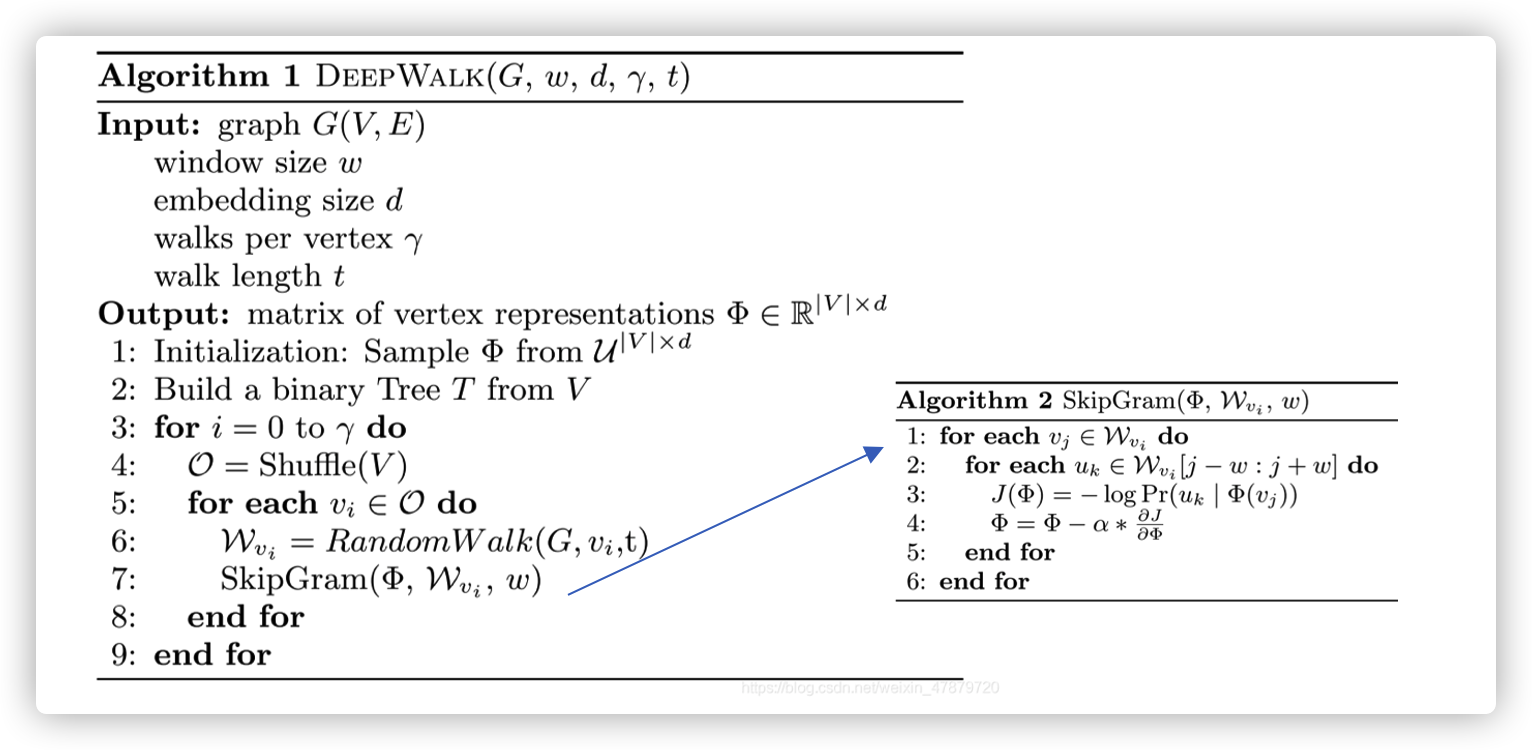


### 2.3 GCN

Kipf and Welling(2017) presented a scalable approach for semi-supervised learning o graph-structured data. This data is based on an efficient variant of convolutional neural networks which operated directly on graphs. Before introducing the mathematical representation and formulars, we firstly try to understand Graph Convolutional Network (GCN). In order to the nodes’ information or features, we can make use of their surrounding proximities (i.e. their neighbors). Some proximities contribute much to this node, while others may have less impacts on it. This impact can be described by weights vectors that is denoted by w_i. The following general formula is the expression of the GCN model.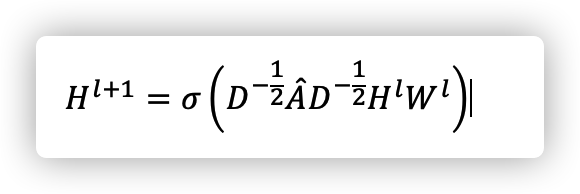
The Symmetric normalized Laplacian is L^sym=D^(-1/2) A ̂D^(-1/2)=D^(-1/2) (D-A) D^(-1/2)=I_n-D^(-1/2) AD^(-1/2), where D is the degree matrix. The L^sym consider the self-connection problem and normalized adjacency matrix

### 2.4 AROPE

A bunch of methods have been proposed to preserve the high-order proximities in network embedding, however, there are two unsolved problems. Embedding with a fixed order do not necessarily perform best on all networks, meanwhile, the existing methods with a certain order cannot guarantee accuracy and efficiency simultaneously (Zhang et al., 2018).  They proposed Arbitrary-order proximity preserved embedding (AROPE) based on SVD framework. The figure show the algorithm of the AROPE. f_i (∙) is the i^th  high-order proximity that is a polynomial function: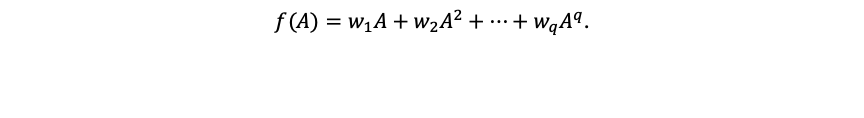
This paper also present the algorithm for solve the optimal problem to find global optimal solution.
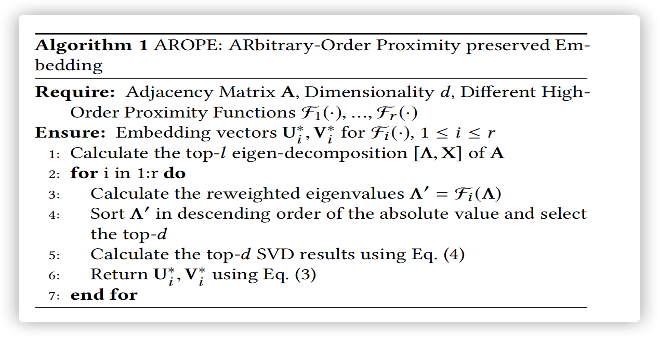

## 3. Empirical Result

### 3.1 Load data

In [1]:
import pandas as pd
import numpy as np
import torch
x=pd.read_csv("data/node_features.csv",header=None)
x=torch.FloatTensor(np.array(x))
edge_index=pd.read_csv("data/edge_index.csv",header=None)
edge_index=torch.tensor(np.array(edge_index.T))
y=pd.read_csv("data/labels.csv",header=None)
y=torch.tensor(y[0])
from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index,y=y,num_classes=10)
data
print('Dataset: Amazon Computers')
print('======================')
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')
print(data)
print('==============================================================')
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Amazon Computers
Number of graphs: 4
Number of features: 767
Number of classes: 10
Data(x=[13752, 767], edge_index=[2, 491722], y=[13752], num_classes=10)
Number of nodes: 13752
Number of edges: 491722
Average node degree: 35.76
Has isolated nodes: True
Has self-loops: False
Is undirected: True


This report main use the data of Amazon Computers network. Nodes represent goods and edges represent those two goods are frequently bought together. The figure shows the basic description of the dataset. In particular, we have 13752 nodes 767 features and 491722 edges. The labels are divided by 10 categories. And we only consider undirected data in this paper. 

### 3.2 GCN model train and test

**parameter settings:

higher layers = 2;

hidden_channels = 100;

trian and test are 2:8 ratio

In [2]:
idx_train = torch.LongTensor(range(int(0.2*data.num_nodes)))# 20% data as train set
idx_test = torch.LongTensor(range(int(0.2*data.num_nodes),data.num_nodes))     # 80% data as test set

In [3]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(123)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 10)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=4).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [5]:
model = GCN(hidden_channels=100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [6]:
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss_train = criterion(out[idx_train], data.y[idx_train])  # Compute the loss solely based on the training nodes.
    loss_train.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss_train

from sklearn.metrics import accuracy_score
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_acc = accuracy_score(data.y[idx_test],pred[idx_test])
    return test_acc

import time
time_start = time.time() 
for epoch in range(1, 100):
    train()
time_end = time.time()
GCN_acc=test()
print(f'Test Accuracy: {GCN_acc:.4f}')
print("time comsume:",(time_end - time_start))
print('done')

Test Accuracy: 0.8827
time comsume: 107.6491231918335
done


### 3.3 DeepWalk model trian and test

**parameter settings:

winndow size = 10;

embedding size = 128;

walks per vertex = 80;

work legth = 10;

trian and test are 2:8 ratio

In [7]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
G=to_networkx(data)

In [9]:
from gensim.models import Word2Vec
from models.walker import RandomWalker

class DeepWalk:
    def __init__(self, graph, walk_length, num_walks, workers=1):

        self.graph = graph
        self.w2v_model = None
        self._embeddings = {}

        self.walker = RandomWalker(
            graph, p=1, q=1, )
        self.sentences = self.walker.simulate_walks(
            num_walks=num_walks, walk_length=walk_length, workers=workers, verbose=1)

    def train(self, embed_size=128, window_size=10, workers=3, iter=10, **kwargs):

        kwargs["sentences"] = self.sentences
        kwargs["min_count"] = kwargs.get("min_count", 0)
        kwargs["vector_size"] = embed_size
        kwargs["sg"] = 1  # skip gram
        kwargs["hs"] = 1  # deepwalk use Hierarchical Softmax
        kwargs["workers"] = workers
        kwargs["window"] = window_size
        kwargs["epochs"] = iter

        print("Learning embedding vectors...")
        model = Word2Vec(**kwargs)
        print("Learning embedding vectors done!")

        self.w2v_model = model
        return model

    def get_embeddings(self, ):
        if self.w2v_model is None:
            print("model not train")
            return {}

        self._embeddings = {}
        for word in self.graph.nodes():
            self._embeddings[word] = self.w2v_model.wv[word]

        return self._embeddings

In [10]:
model = DeepWalk(G, walk_length=10, num_walks=80, workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.5s finished


In [11]:
time_start = time.time() 
model.train(window_size=5, iter=10)
time_end = time.time() 
print('done')

Learning embedding vectors...
Learning embedding vectors done!
done


In [12]:
from models.classify import Classifier
from sklearn.linear_model import LogisticRegression
X,Y=list(range(data.num_nodes)),[str(x) for x in data.y.tolist()]
tr_frac=0.2 #Training classifier using 20.00% nodes...
embeddings = model.get_embeddings()
clf = Classifier(embeddings=embeddings, clf=LogisticRegression())
DeepWalk_acc=clf.split_train_evaluate(X, Y, tr_frac)['acc']

print(f'Test Accuracy: {DeepWalk_acc:.4f}')
print("time comsume:",(time_end - time_start))

Test Accuracy: 0.8803
time comsume: 1127.7905938625336


### 3.4 AROPE

According to the paper, the algorithm of nodes classification task is require to design.
step 1: slipt the nodes into trianning set and testing set as 2:8 ratiao
step 2: train a ovr (=ova) logistical regression with L2 regression (default=L2) using content embedding vectors
        on train and test set
step 3: evaluate by accuraccy

remark  the eigenvector centrality is a spacial case as to do node classfication task. it suggested that the dimention is 1 regardless of what high-order proximity is used.

In [13]:
def AROPE(A, d, order, weights):
    # A: adjacency matrix A or its variations, sparse scipy matrix
    # d: dimensionality
    # r different high-order proximity:
    # order: 1 x r vector, order of the proximity
    # weights: 1 x r list, each containing the weights for one high-order proximity
    # return: 1 x r list, each containing the embedding vectors
    A = A.asfptype()
    lambd, X = Eigen_TopL(A, d)
    r = len(order)
    U_output, V_output = [], []
    for i in range(r):
        U_temp, V_temp = Shift_Embedding(lambd, X, order[i], weights[i], d)
        U_output.append(U_temp)
        V_output.append(V_temp)
    return U_output, V_output

In [15]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import models.utils as utils

In [16]:
data = pd.read_csv('data/edge_index.csv') 
data = np.array(data)
N = np.max(data)+1
A = csr_matrix((np.ones(data.shape[0]), (data[:,0],data[:,1])), shape = (N,N))
A += A.T
A.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
order = [1,2,3,-1]
weights = []
weights.append([1])
weights.append([1,0.1])
weights.append([1,0.1,0.01])
weights.append([0.001])

print("order:\t\t",order)
print("weights:\t",weights)

order:		 [1, 2, 3, -1]
weights:	 [[1], [1, 0.1], [1, 0.1, 0.01], [0.001]]


In [18]:
U_list,V_list = utils.AROPE(A,128,order,weights)

In [20]:
len(U_list[0])

13752

In [25]:
from models.classify import Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf=LogisticRegression(random_state=0,multi_class='ovr').fit(U_list[0][:2749], y[:2749])

pred=clf.predict(U_list[0][2749:],)

AROPE_acc=accuracy_score(y[2749:], pred)

In [26]:
print('the accuraccy of GCN model:\t\t', GCN_acc)
print('the accuraccy of DeepWalk model:\t', DeepWalk_acc)
print('the accuraccy of AROPE model:\t\t', AROPE_acc)

the accuraccy of GCN model:		 0.8827485911652427
the accuraccy of DeepWalk model:	 0.8802944919105617
the accuraccy of AROPE model:		 0.7213487230755249


# 4.Conclusion

This report aims to excute node classification task. Three main graph network methods are applied to construced nonde classification model. They are Graph Convolution Network, Deepwalk and Arbitrary-Order Promixity Preserved Embedding models. we try to reproduce these models and compare thire performance using one dataset that are Amazon Computer Network data. The main evaluatio metrice are F1-score and accuracy. Here, we only consider the accuracy of these models.

we split data into 2:8 ratio as tarin and test set. By training the GCN model 100 epochs, the test accuracy is 0.88. on the contrary, we train the deepwalk model 10 epochs the accuraccy is 0.88. they have similar result. However, for interation oepration, the GCN model is not time-consuming, as the running time is 107s for 100 epochs. we only operate 10 epochs for deepwalk model, then it requires 1120s running time. For the AROPE model, its accuracy is 0.72,but it runing time is less than 1s.

If we try to more iteration, it perhaps get higer accuracy. So it is tradeoff between model perfoemance and time-consumming problem. If we try to more iteration, it perhaps get higer accuracy. So it is tradeoff between model perfoemance and time-consumming problem.

# Reference

@inproceedings{zhang2018arbitrary,
  title={Arbitrary-Order Proximity Preserved Network Embedding},
  author={Zhang, Ziwei and Cui, Peng and Wang, Xiao and Pei, Jian and Yao, Xuanrong and Zhu, Wenwu},
  booktitle={Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery \& Data Mining},
  pages={2778--2786},
  year={2018},
  organization={ACM}
}



Fey, M. and Lenssen, J.E. (2019) ‘FAST GRAPH REPRESENTATION LEARNING WITH PYTORCH GEOMETRIC’.

Kipf, T.N. and Welling, M. (2017) ‘SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS’.

Perozzi, B., Al-Rfou, R. and Skiena, S. (2014) ‘DeepWalk: online learning of social representations’, in Proceedings of the 20th ACM SIGKDD international conference on Knowledge discovery and data mining. KDD ’14: The 20th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, New York New York USA: ACM, pp. 701–710. Available at: https://doi.org/10.1145/2623330.2623732.

Shmueli, B. (2019) Tutorial on NLP-Inspired Network Embedding, arXiv.org. Available at: https://doi.org/10.48550/arXiv.1910.07212.

Zhang, Z. et al. (2018) ‘Arbitrary-Order Proximity Preserved Network Embedding’, in Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. KDD ’18: The 24th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, London United Kingdom: ACM, pp. 2778–2786. Available at: https://doi.org/10.1145/3219819.3219969.

